In [78]:
# imports
from src.data.utils import gedi_utils
from src.data.pipelines.extract_gedi_data import SIERRAS_GEDI_ID_COLUMNS, SEKI_GEDI_ID_COLUMNS, SIERRAS_GEDI_ALL_COLUMNS, SEKI_GEDI_ALL_COLUMNS
from src.data.gedi import gedi_loader
from src.constants import DATA_PATH, GEDI_INTERMEDIATE_PATH, INTERMEDIATE_RESULTS
from fastai.tabular.all import load_pickle, save_pickle
from src.data.processing import severity_overlay as se
from src.data.processing import raster_overlays as ro
from src.data.adapters import calfire_perimeters as cp
from src.data.pipelines import run_overlays as overlays
from src.data.adapters import mtbs as mtbs_adapter
from src.data.pipelines import aggregate_analysis as aa
import numpy as np
from scipy import stats
import statsmodels.api as sm
from src.utils.eval import mse, rmse, r_squared

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", palette="Set2")
palette = sns.color_palette("Set2")

from src.counterfactuals.nearby import nearby
from src.counterfactuals.matching import matching

import pandas as pd

import importlib
importlib.reload(se)
importlib.reload(ro)
importlib.reload(gedi_utils)
importlib.reload(aa)
importlib.reload(nearby)

2024-02-01 01:23:29,806 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/severity_overlay.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-01 01:23:29,825 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/raster_overlays.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-01 01:23:29,889 DEBUG: Logger /home/jk871/fire-regen/src/counterfactuals/nearby/nearby.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.counterfactuals.nearby.nearby' from '/home/jk871/fire-regen/src/counterfactuals/nearby/nearby.py'>

In [87]:
import numpy as np
from scipy.stats import linregress

def rma_regression(x, y):
  """
  Calculates the Reduced Major Axis (RMA) regression line.

  Args:
    x: The independent variable.
    y: The dependent variable.

  Returns:
    A tuple of (slope, intercept).
  """

  # Calculate the ordinary least squares (OLS) regression line.
  slope, intercept, r_value, p_value, std_err = linregress(x, y)

  # Calculate the covariance between x and y.
  cov = np.cov(x, y)[0, 1]

  # Calculate the variance of x.
  var_x = np.var(x)

  # Calculate the slope of the RMA regression line.
  rma_slope = cov / var_x

  # Calculate the intercept of the RMA regression line.
  rma_intercept = intercept - rma_slope * np.mean(x)

  return rma_slope, rma_intercept

import matplotlib.pyplot as plt 
import numpy as np    

def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    sns.lineplot(x=x_vals, y=y_vals, ax=ax)

In [79]:
INPUT_PATH = f"{DATA_PATH}/counterfactuals/matching"

In [81]:
df = load_pickle(f"{INPUT_PATH}/matching_placebo_set_1_1.pkl").dropna()

In [83]:
df.columns

Index(['geometry', 'agbd', 'cover', 'fhd_normal', 'pai', 'rh_25', 'rh_50',
       'rh_70', 'rh_98', 'slope', 'elevation', 'ndvi_2019', 'ndvi_2018',
       'ndvi_2017', 'ndvi_2016', 'ndvi_2015', 'ndvi_2020', 'ndvi_2021',
       'ndvi_2022', 'ndvi_2010', 'pai_cf', 'rh_98_cf', 'rh_70_cf', 'rh_50_cf',
       'cover_cf', 'ndvi_2020_cf', 'ndvi_2021_cf', 'ndvi_2022_cf'],
      dtype='object')

In [88]:
def evaluate_placebo_set(outcome_variable, df):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    print(f"Evaluating Placebo Set 1:")
    #df = load_pickle(f"{INPUT_PATH}/matching_placebo_set_1_1.pkl").dropna()
    x_cf = df[f"{outcome_variable}_cf"]
    x = df[outcome_variable]
    outcome_diff = x_cf - x

    # Print stats
    a = rmse(x, x_cf)
    b = r_squared(x, x_cf)
    print(f"RMSE: {a}")
    print(f"R^2: {b}")
    print(f"RMA regression: {rma_regression(x, x_cf)}")

    sns.kdeplot(outcome_diff, ax=ax)
    ax.axvline(x=0)


Evaluating Placebo Set 1:
RMSE: 0.042313611749133596
R^2: 0.874511585040011
RMA regression: (0.9133472638892656, -0.5846053437562381)
Evaluating Placebo Set 1:
RMSE: 0.051395203924832406
R^2: 0.8116358377232165
RMA regression: (0.8801327311620895, -0.530979970791659)


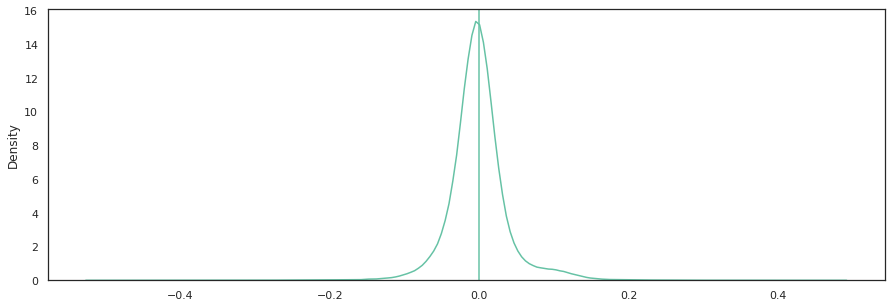

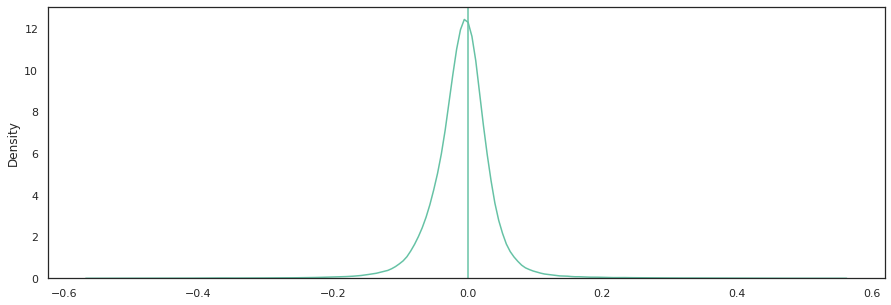

In [90]:
evaluate_placebo_set("ndvi_2020", df)
evaluate_placebo_set("ndvi_2021", df)

Evaluating Placebo Set 1:
RMSE: 12.462390158530871
R^2: -0.3137279274886373
RMA regression: (0.3673938288418425, 6.675535770099398)


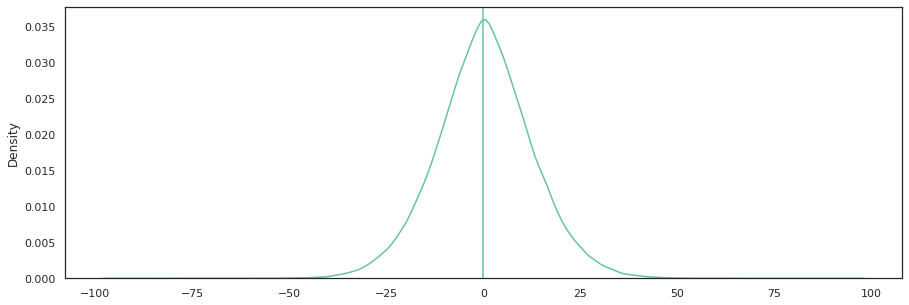

In [91]:
evaluate_placebo_set("rh_98", df)

Evaluating Placebo Set 1:
RMSE: 9.929582767187908
R^2: -0.226789907116542
RMA regression: (0.4132154583259498, 2.5432677141927584)


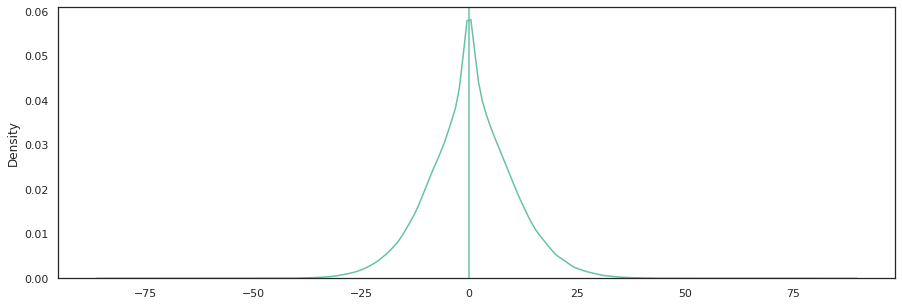

In [92]:
evaluate_placebo_set("rh_70", df)

Evaluating Placebo Set 1:
RMSE: 8.008540839028297
R^2: -0.21452392877107895
RMA regression: (0.4282595746292606, 1.389005981531449)


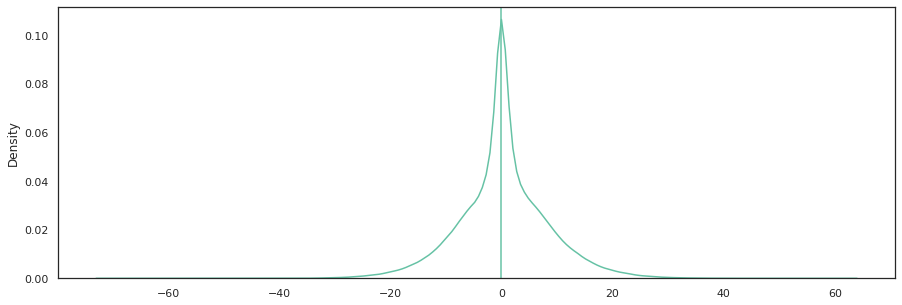

In [93]:
evaluate_placebo_set("rh_50", df)

Evaluating Placebo Set 1:
RMSE: 1.72274169108647
R^2: -0.41054526901370303
RMA regression: (0.30354625111607014, 0.753234297695924)


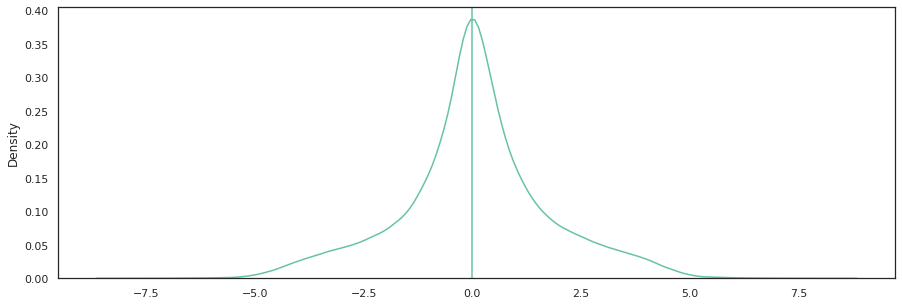

In [94]:
evaluate_placebo_set("pai", df)

Evaluating Placebo Set 1:
RMSE: 0.30579336591509737
R^2: -0.30726917215857763
RMA regression: (0.3464706939225151, 0.16229468698163985)


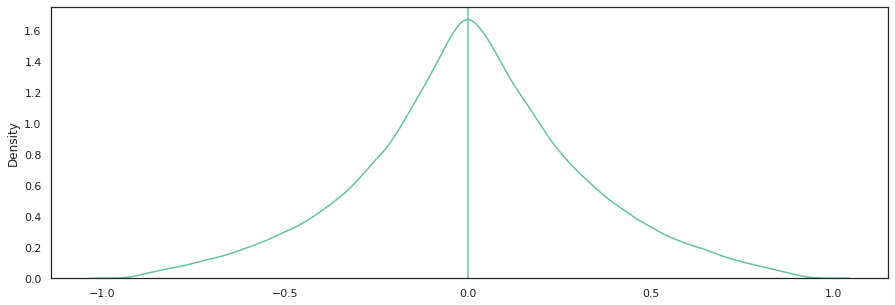

In [95]:
evaluate_placebo_set("cover", df)

### Scatter

(0.0, 1.0)

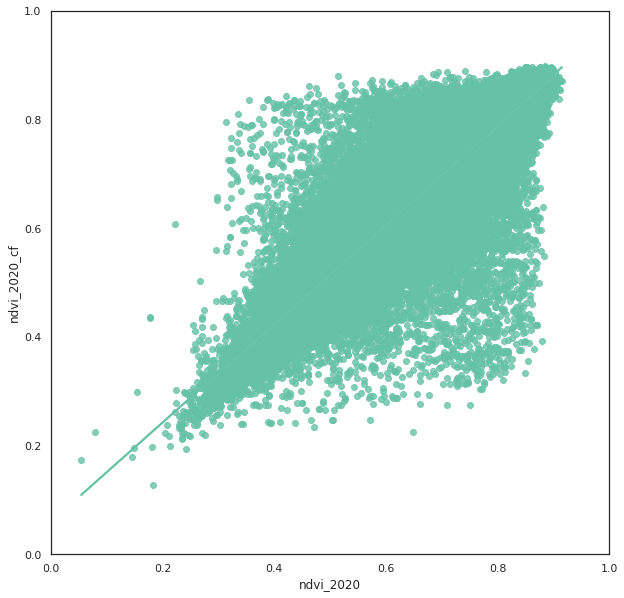

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.regplot(df, x="ndvi_2020", y="ndvi_2020_cf")
ax.set_xlim((0,1))
ax.set_ylim((0,1))

(0.0, 1.0)

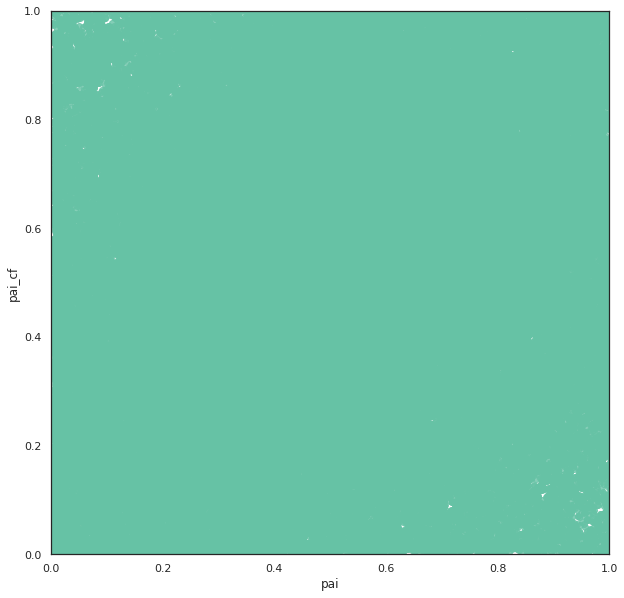

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.regplot(df, x="pai", y="pai_cf")
ax.set_xlim((0,1))
ax.set_ylim((0,1))

Evaluating Placebo Set 1:
RMSE: 1.72274169108647
R^2: -0.41054526901370303
RMA regression: (0.30354625111607014, 0.753234297695924)


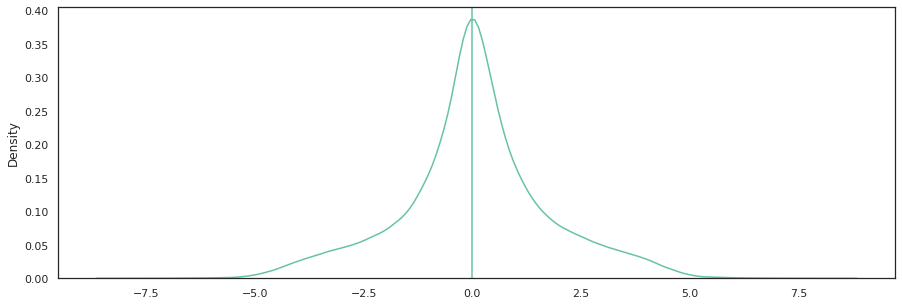

In [99]:
evaluate_placebo_set("pai", df)

Evaluating Placebo Set 1:
RMSE: 8.008540839028297
R^2: -0.21452392877107895
RMA regression: (0.4282595746292606, 1.389005981531449)


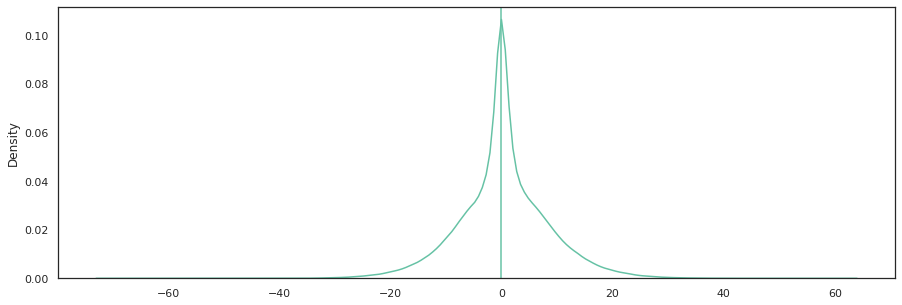

In [104]:
evaluate_placebo_set("rh_50", df)

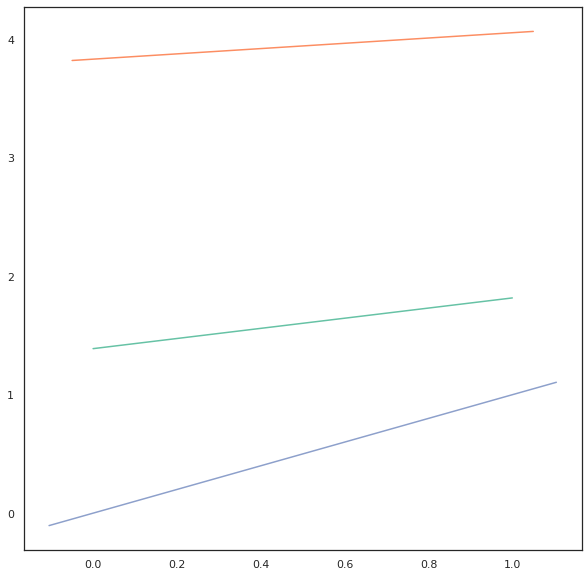

In [107]:
# RH 50
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
abline(0.4282595746292606, 1.389005981531449, ax)
abline(0.22315670235024201, 3.83328559236233, ax)
abline(1, 0, ax)
#ax.set_xlim((0,5))
#ax.set_ylim((0,5))

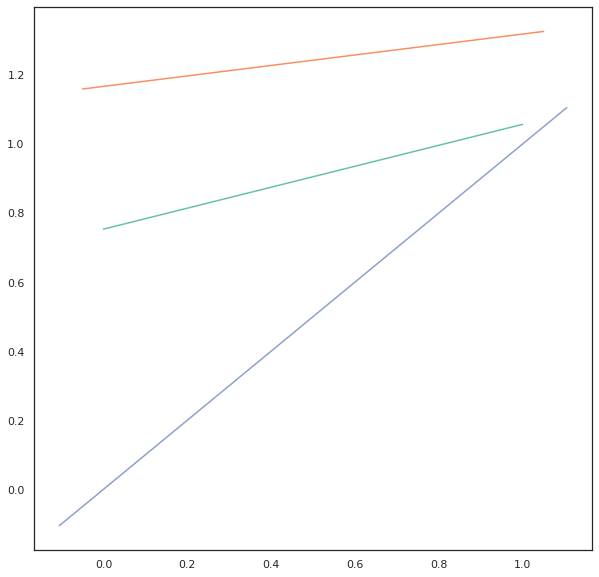

In [103]:
# PAI
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
abline(0.30354625111607014, 0.753234297695924, ax)
abline(0.15158848332938954, 1.1665482154456872, ax)
abline(1, 0, ax)
##ax.set_xlim((0,1))
#ax.set_ylim((0,1))

In [3]:
df = load_pickle(f"{aa.PIPELINES_PATH}/severity_aggregated_info_da.pkl")

In [2]:
df = load_pickle(f"{aa.PIPELINES_PATH}/seki_severity_aggregated_info.pkl")

In [3]:
unburned = df[df.YSF < 0]

In [32]:
sample = unburned.sample(1000)

In [33]:
out_sample = unburned[~unburned.index.isin(sample.index)].sample(10000)

In [71]:
left_df.isna().values.any()

False

In [35]:
left_df = sample[["elevation", "slope", "ndvi"]].dropna()
print(len(left_df))

right_df = out_sample[["elevation", "slope", "ndvi"]].dropna()
print(len(right_df))

998
9981


In [36]:
left = left_df.to_numpy()
right = right_df.to_numpy()

In [8]:
V_INV = np.linalg.pinv(np.cov(right))

In [14]:
V_INV.shape

(10000, 10000)

In [37]:
V = np.cov(right, rowvar=False)

In [38]:
V.shape

(3, 3)

In [18]:
right.shape

(10000, 2)

In [39]:
tree = BallTree(right, leaf_size=15, metric='mahalanobis', V=np.cov(right, rowvar=False))

In [42]:
dist, indeces = tree.query(left, k=5)

In [45]:
indeces

array([[5934, 3215, 6787,  924,  449],
       [8296, 2616, 9028, 3885, 5656],
       [2453, 6687, 3840, 5476, 2875],
       ...,
       [7524, 9399, 6572, 9799, 8256],
       [ 708, 1076, 2552, 3544,  541],
       [2780, 9562, 4572, 5930, 5229]])

In [50]:
indeces[:, 0]

array([5934, 8296, 2453,  400, 9506, 8802, 5631, 5738, 8311, 8802, 5296,
       2229, 3092, 6040, 8872, 7467, 4032, 2314, 8111, 9268, 5297, 5252,
       6537,  932, 9035, 3044, 7611, 8847, 1977, 2100, 2451, 9800, 6892,
       7883, 7246, 7259, 7917, 4877, 1556, 4551, 9304, 6000, 8130, 1639,
       3332, 1200, 4682, 6988, 1469, 6018, 8839,  480, 6115, 9348, 6008,
       4824, 6215, 1806,  590, 7052, 5574, 5142, 8766, 6053, 9925, 3357,
        650, 7960, 6817, 8633, 6711, 1463, 6396, 8782, 2374, 1500, 1109,
       4067, 1712, 1242,  777, 4112,  672, 8789, 4004, 2539, 3662, 6618,
       5370, 9785, 5187, 6902, 5211, 7093, 9266, 1258, 4662, 3362, 5445,
       9454, 4085, 1454, 4386, 4679, 1554, 8490, 3488, 3849, 7549,  978,
       3458, 5635, 9353, 8275,  504, 8068, 6162, 2194, 7039, 8032, 6455,
       7132, 9617, 7759, 9135, 8669, 1540, 6367,  613, 8657, 9789, 3682,
       4749, 6682, 4950, 1137, 6730, 4971, 1748, 7149, 3543, 3601, 9580,
        212, 5629,  649, 9409, 4727, 5058, 3053,  7

In [72]:
matches = right_df.iloc[indeces[:, 4]]

In [75]:
matches.index

Index([ 53780800300290359, 141320600300529163, 213880500200258625,
       180510600300534147, 176500500200099913, 160641100200118977,
       103610300200188700, 202131100200080380, 177110800200085639,
       132280500200188766,
       ...
       188291100300307809, 104830600200437583, 160640800200123232,
       228680800200123239, 228680800200122677,  90800300200151180,
        92020500200081027, 184890300200080395, 161250500200138624,
        53780600300533092],
      dtype='int64', name='shot_number', length=998)

In [77]:
right_df.loc[matches.index]

,elevation,slope,ndvi
shot_number,,,
53780800300290359,1311.5,20.088871,0.714938
141320600300529163,2755.5,23.299820,0.583236
213880500200258625,1262.5,28.190563,0.694226
180510600300534147,1128.0,28.608070,0.635569
176500500200099913,2969.0,4.390715,0.523093
...,...,...,...
90800300200151180,1440.5,8.135839,0.749829
92020500200081027,2780.5,9.804636,0.542206
184890300200080395,1598.0,27.034594,0.628319


In [65]:
(left_df.ndvi.mean() - matches.ndvi.mean()) / (left_df.ndvi.std())

-0.006495533783931393

In [66]:
(left_df.elevation.mean() - matches.elevation.mean()) / (left_df.elevation.std())

0.0026199121

In [67]:
(left_df.slope.mean() - matches.slope.mean()) / (left_df.slope.std())

0.0040500574

In [33]:
left[0], right[3157], right[3061]

(array([1443.      ,   17.129251], dtype=float32),
 array([1440.5    ,   18.84499], dtype=float32),
 array([1443.5     ,   12.250124], dtype=float32))

In [29]:
left[1], right[3677], right[1323]

(array([2195.5    ,   31.32825], dtype=float32),
 array([2051.      ,   25.056166], dtype=float32),
 array([2861.5    ,   18.73943], dtype=float32))

In [30]:
left[0]

array([1443.      ,   17.129251], dtype=float32)

In [ ]:
out_sample[(out_sample.elevation > 1243) & (out_sample)]